In [92]:
from PIL import Image, ImageOps
import numpy as np

In [93]:
# all units in mm

PEN_DIAMETER      = 15
GANTRY_LENGTH     = 700
RESOLUTION_X      = PEN_DIAMETER
RESOLUTION_Y      = 1

TRIPLE_SCRUBBING  = False
TWO_COLORS        = True

INPUT_IMAGE       = "test5.png"

In [94]:
def debug_display(img):
    debug_img = img.resize((
        int(img.width*RESOLUTION_X*2), 
        int(img.height*RESOLUTION_Y*2)
    ), resample=Image.Resampling.NEAREST)
    display(debug_img)

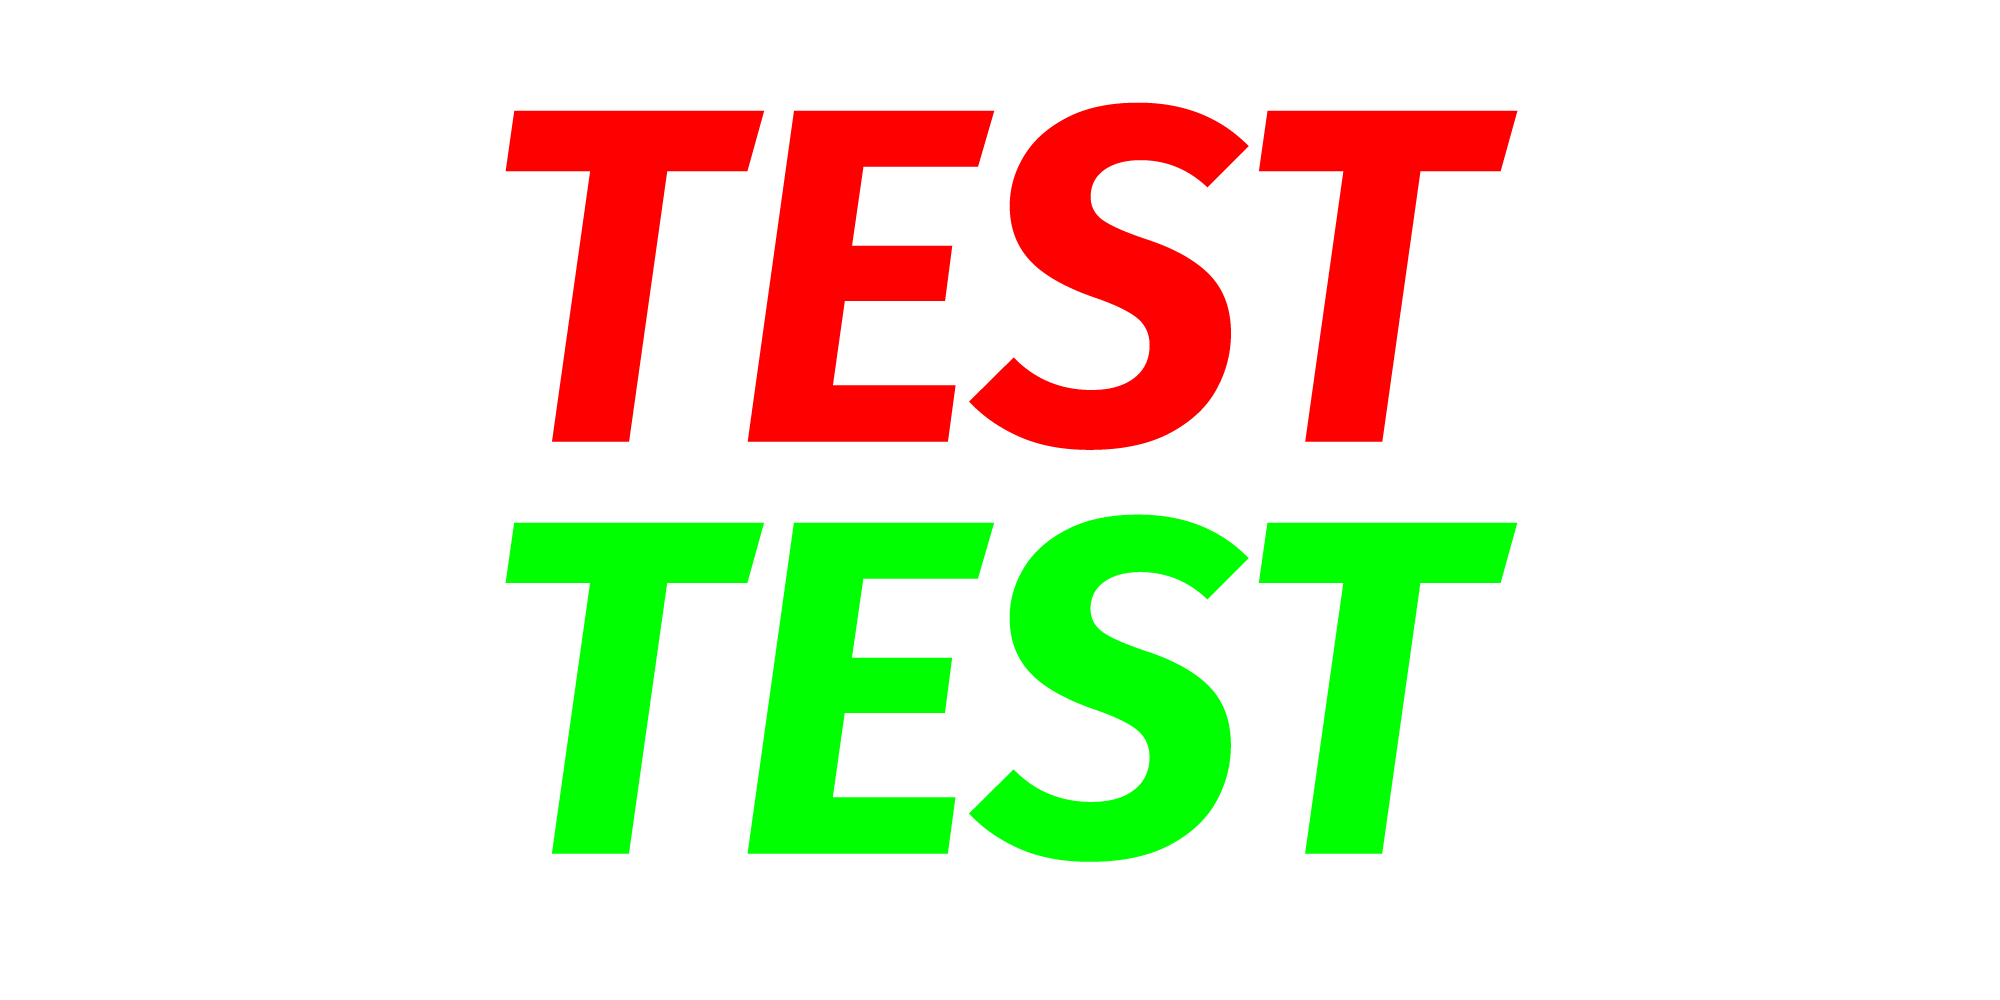

In [95]:
img = Image.open(INPUT_IMAGE)
display(img)

In [96]:
if img.width < img.height:
    img = img.transpose()

layer 0


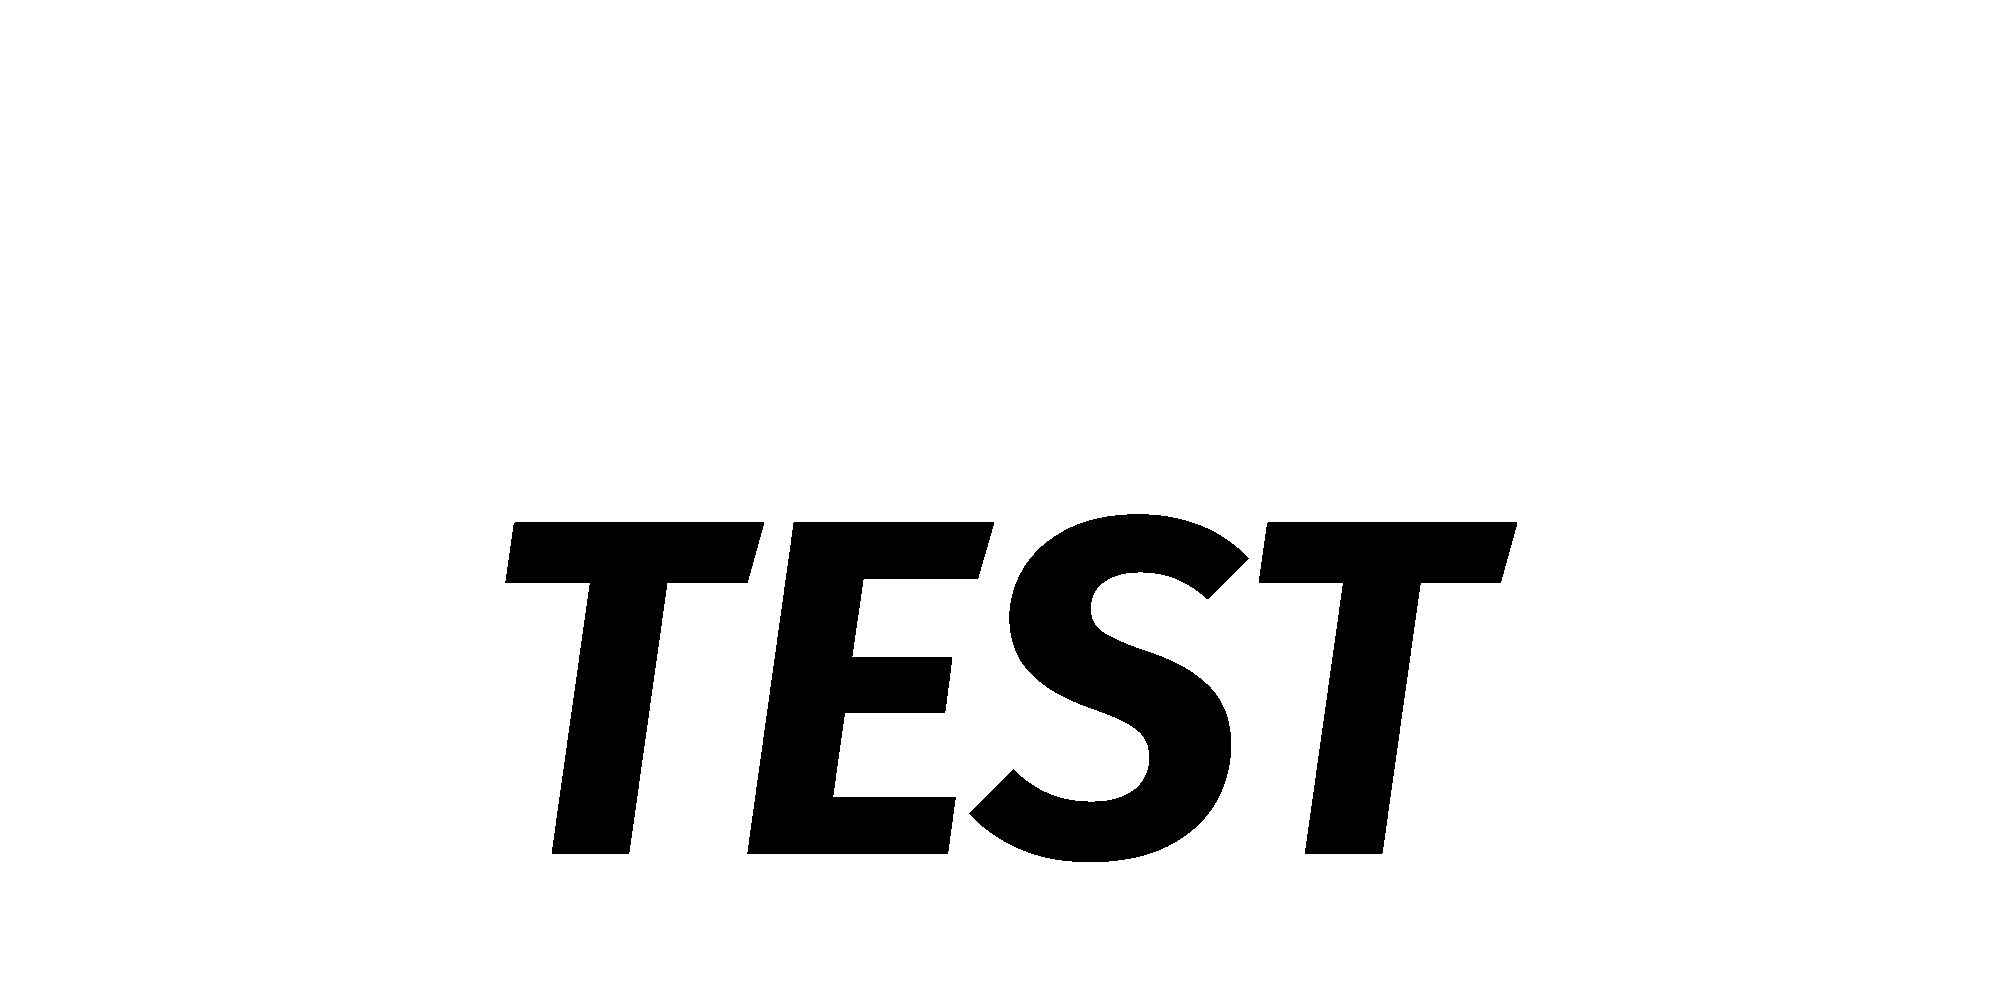

layer 1


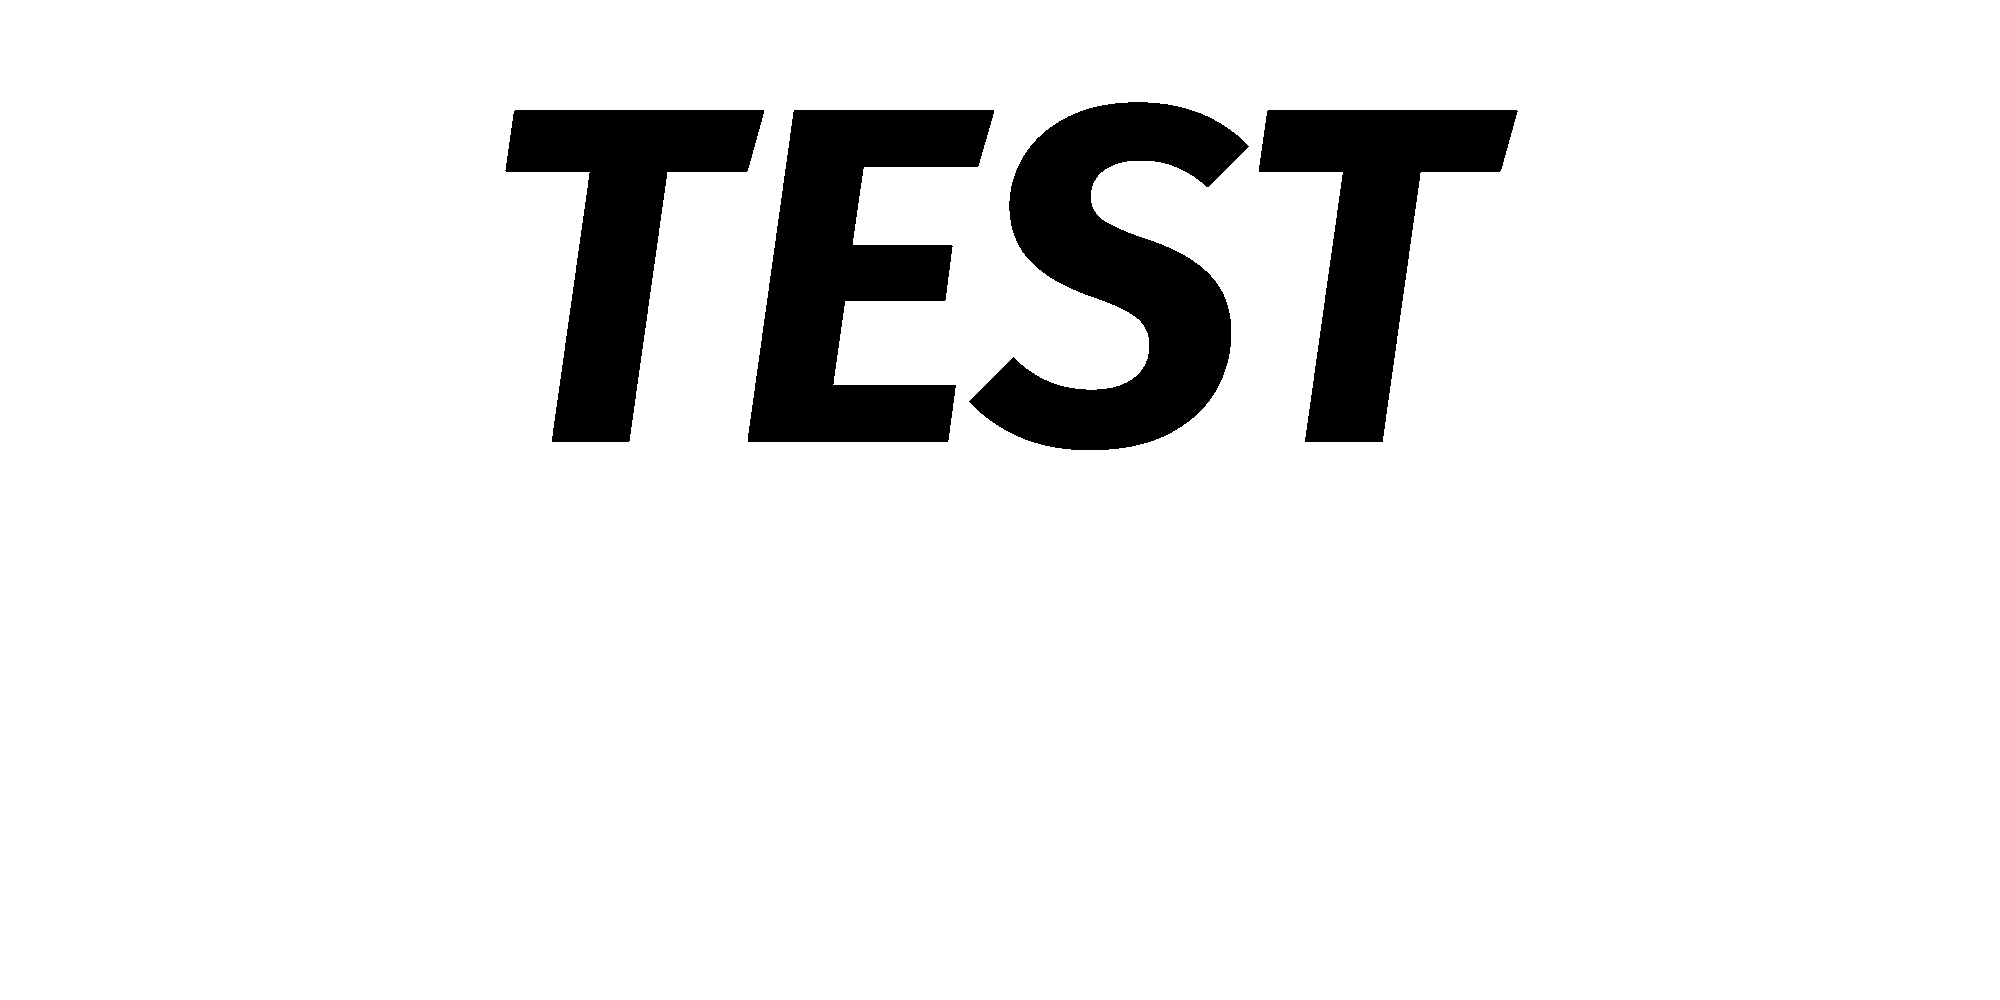

In [107]:
layers = []
if TWO_COLORS:
    layer0 = np.where(np.array(img)[:,:,0] > 200, 255, 0)
    layer0 = Image.fromarray(layer0.astype(np.uint8)).convert(mode="1")
    layers.append(layer0)
    layer1 = np.where(np.array(img)[:,:,1] > 200, 255, 0)
    layer1 = Image.fromarray(layer1.astype(np.uint8)).convert(mode="1")
    layers.append(layer1)
else:
    img = img.convert(mode="1")
    img = ImageOps.invert(img)
    layers.append(img)

for i in range(len(layers)):
    print("layer {}".format(i))
    display(layers[i])

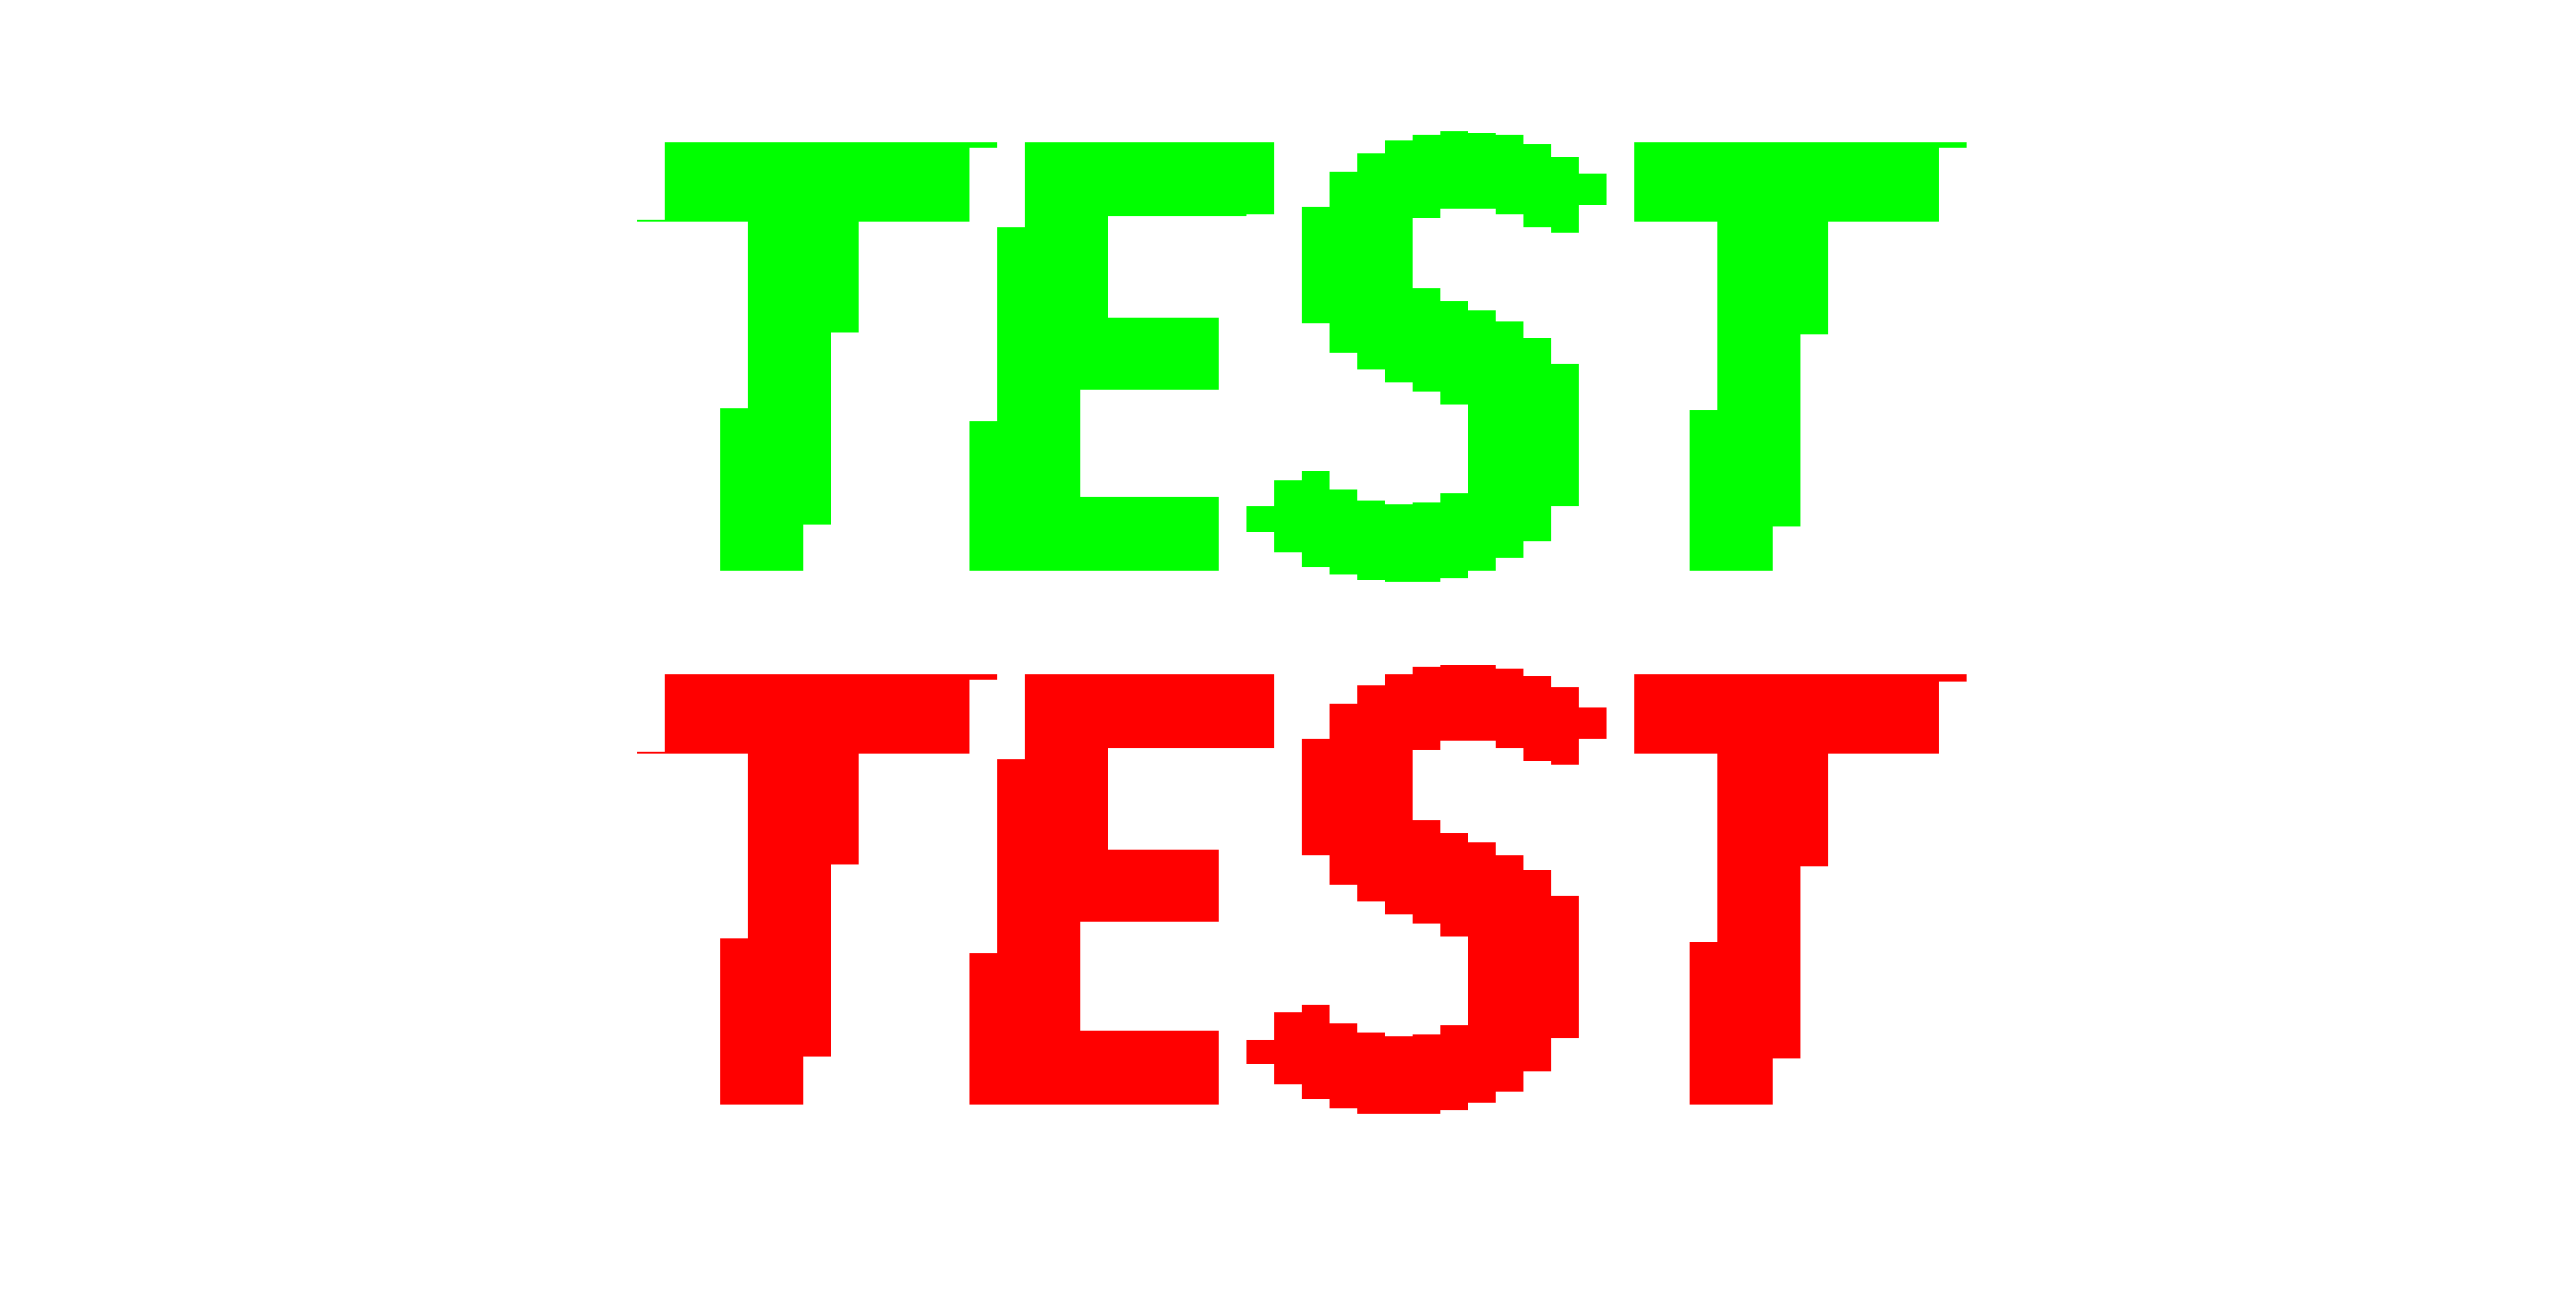

In [103]:
resize_height = int(GANTRY_LENGTH / RESOLUTION_Y)
resize_width = int(img.width / img.height * GANTRY_LENGTH / RESOLUTION_X)

combined_image = np.zeros([resize_height, resize_width], dtype=np.uint8)
combined_image_debug = np.zeros([resize_height, resize_width, 3], dtype=np.uint8)

for i in range(len(layers)):
    layers[i] = layers[i].resize((
        resize_width,
        resize_height
    ))
    #), resample=Image.Resampling.LANCZOS)
    
    #display(layers[i])
    #debug_display(layers[i])

    layer_array = np.array(layers[i])
    inverted = np.invert(layer_array) * (i+1)
    inverted = inverted.astype(np.uint8)
    combined_image = np.add(combined_image, inverted)

    color = [0, 0, 0]
    color[i] = 255
    combined_image_debug[layer_array == 0] = color

combined_image_debug[combined_image == 0] = [255, 255, 255]

debug_display(Image.fromarray(combined_image_debug))

In [109]:
segments = []
segment_start = None
for x in range(combined_image.shape[1]):
    segments_line = []
    
    segment_start = None
    last_color = 0
    
    for y in range(combined_image.shape[0]):
        current_color = combined_image[y, x]

        if current_color != last_color:
            if segment_start is None:
                segment_start = [x*RESOLUTION_X, y*RESOLUTION_Y]
            else:
                segment = [segment_start, [x*RESOLUTION_X, y*RESOLUTION_Y], last_color]
                
                #segment_length = abs(segment[0][1]-segment[1][1])
                #if segment_length >= PEN_DIAMETER:
                #    segments_line.append(segment)

                segments_line.append(segment)

                if current_color == 0:
                    segment_start = None
                else:
                    segment_start = [x*RESOLUTION_X, y*RESOLUTION_Y]
                    
            last_color = current_color

    # column ends but line segment is unfinished
    if segment_start is not None:
        segment = [segment_start, [x*RESOLUTION_X, y*RESOLUTION_Y], last_color]
        segments_line.append(segment)
        segment_start = None
    
    if len(segments_line) > 0:
        segments.append(segments_line)

#for l in segments:
#    for s in l:
#        print(s)
#    print("---")
print(img_resized.width*RESOLUTION_X, img_resized.height*RESOLUTION_Y)

1395 700


In [100]:
def write_gcode(segments, filename, params={}):
    
    FEEDRATE_X = 2000
    FEEDRATE_Y = 8000
    FEEDRATE_Z_RAISE = 2000
    FEEDRATE_Z_LOWER = 4000

    RAISE_DISTANCE = 50
    
    START_CMD           = """
G90                                 
G21                     
G28  
G92 X0 Y0 Z0

G1 F{feedrate}
"""
    
    MOVEX_CMD            = """
G1 F{feedrate}
G1 X{x:.4f}
"""

    MOVEY_CMD            = """
G1 F{feedrate}
G1 Y{y:.4f}
"""

    LOWER_CMD           = """
G1 F{feedrate}
G1 Z{z:.4f}
"""

    RAISE_CMD           = """
G1 F{feedrate}
G1 Z{z:.4f}
"""

    END_CMD             = """
G1 F{feedrate}
G1 X0 
G1 X0 Y0 
G92 X0 Y0 Z0 A0       
"""
    
    with open(filename, "w") as f:

        f.write("(ChalkRoll --- date: {} / feedrate: {} {} {} {})\n".format(
            "?", FEEDRATE_X, FEEDRATE_Y, FEEDRATE_Z_RAISE, FEEDRATE_Z_LOWER
        ))

        for key in params.keys():
            f.write("(info: {} : {})\n".format(key, params[key]))

        f.write(START_CMD.format(
            feedrate=FEEDRATE_X,
        ))
        f.write(RAISE_CMD.format(
            z = RAISE_DISTANCE,
            feedrate=FEEDRATE_Z_RAISE
        ))

        for line in segments:

            if len(line) == 0:
                continue
            
            first_segment_in_line = line[0]

            f.write(MOVEX_CMD.format(
                x = first_segment_in_line[0][0],
                feedrate=FEEDRATE_X
            ))
            
            for s in line:

                f.write(MOVEY_CMD.format(
                    y = s[0][1],
                    feedrate=FEEDRATE_Y
                ))
    
                f.write(LOWER_CMD.format(
                    z = 0,
                    feedrate=FEEDRATE_Z_LOWER
                ))
    
                f.write(MOVEY_CMD.format(
                    y = s[1][1],
                    feedrate=FEEDRATE_Y
                ))

                if TRIPLE_SCRUBBING:
                    f.write(MOVEY_CMD.format(
                        y = s[0][1],
                        feedrate=FEEDRATE_Y
                    ))
                    f.write(MOVEY_CMD.format(
                        y = s[1][1],
                        feedrate=FEEDRATE_Y
                    ))

                f.write(RAISE_CMD.format(
                    z = RAISE_DISTANCE,
                    feedrate=FEEDRATE_Z_RAISE
                ))

        f.write(END_CMD.format(
            feedrate=FEEDRATE_X
        ))
    

In [101]:
segments_reversed = []
for i in range(len(segments)):
    line = segments[i]
    if i%2==0:
        segments_reversed.append(line)
    else:
        segments_reversed.append(list(reversed([list(reversed(s)) for s in line])))
segments = segments_reversed

write_gcode(segments, "output.gcode")

print("number of lines: {}".format(len(segments)))

IndexError: invalid index to scalar variable.